# Titanic Survival ML Prediction 

In this project, we will try to predict from the test data who survived on the RMS Titanic after colliding with an iceberg on April15, 1912 using some machine learning on the training data availble with us from Kaggle: https://www.kaggle.com/competitions/titanic/overview

We are given two datasets: train.csv and test.csv to train and make predictions

Below are the columns we have in our datasets:

- **PassengerId:**  Unique ID of passenger aboard the ship
- **Survived:**  0 = No, 1 = Yes (Only in the training data)
- **Pclass:**  Ticket class (1,2,3)
- **Name:**  Name of the passenger
- **Sex:**  male, female
- **Age (in years)**
- **SibSp:**  # of siblings / spouses aboard the Titanic	
- **Parch:**  # of parents / children aboard the Titanic	
- **Ticket:**  Ticket number	
- **Fare:**  Passenger fare	
- **Cabin:**  Cabin number	
- **Embarked:**  Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

We will start with our project by importing all the required libraries

<br>

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

#### Setting the plotting style to Seaborn default

In [2]:
sns.set()

<br>

# Importing the training dataset

In [3]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We'll do some preliminary study on this dataframe

In [4]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


- There are total 891 observations/rows.
- Age and embarked column data are missing.
- A significant amount of Cabin data are missing which renders it useless as a feature.

The isnull() method combined with the sum() method gives us the exact number of missing values

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Now we copy this dataframe to a new variable: df_train on which we will do our feature engineering and cleaning on

In [6]:
df_train = train.copy()

<br>

# Dealing with missing values

We need to deal with missing values of - Age, Embarked and Cabin columns.
- For age, we will have to think of some imputing method to fill the values with since deleting the 177 rows will cost us too much information.
- We can afford to delete two rows where embarked column has missing values.
- We will delete the entire Cabin column since it has no use for us whatsoever

First, we'll delete the Cabin column

In [7]:
df_train.drop('Cabin',axis=1,inplace=True)

### Imputing method for filling missing age column

We can easily fill the missing age values with the mean of all ages present. But this will not be accurate since the range of age is pretty large (0-80 years).

Instead, we'll use a column in the current dataframe that will help us classify the age range of the person. While this information is not straightforwardly available, if we look carefully at the name column, we can see that it's written in a specific order: 
#### Surname, Title. Name

What does the title tell us?

- Master: A young boy
- Miss: A young girl
- Mr: A man
- Mrs: A married woman
- And so on...

(Note: There is no hard and fast definition for some of these titles and as of the present time, they are used flexibly)

Thus, we can extract this title information from the name and calculate the individual mean for people with these titles and then assign this mean to the age value. This way, the error will be reduced as compared to assigning the whole dataset mean.

In [8]:
#Using split method of strings, we create a list using ',' as the delimiter and then extract the name followed by another split
#with '.' as the delimiter and strip the whitespaces of the 0th index which is our title

df_train['Title'] = df_train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [9]:
df_train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

As we can see, we have 17 unique titles

Now we use the groupby method along with the transform method to calculate the means of the ages when grouped according the titles listed above. Using transform, we then assign this mean value to each of the missing values in Age column in the dataframe.

In [10]:
df_train['Age'] = df_train['Age'].fillna(df_train.groupby('Title')['Age'].transform('mean'))

With all the missing age values filled, all that's left are the two embarked missing values. We'll use the dropna() method to delete those two rows.

In [11]:
df_train.dropna(subset='Embarked',inplace=True)

Now we have finally dealt with all the missing values. Let's confirm this by using the isnull() method again.

In [12]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

<br>

# Feature Extraction

In this section we will try to extract some information from the tickets column.

As of now, we are unsure as to what type of information we are expecting. So we will start by just exploring the ticket column and what kind of data it holds.

In [13]:
df_train['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It seems like it has a ticket number in all the tickets but in some tickets has some kind of alpha-numeric code leading the ticket number.

Let's try to extract this code.

In [14]:
#We store the aplha-numeric code in the newly created column Ticket_type. If no code exists we'll assign it a '0'

df_train['Ticket_type'] = df_train['Ticket'].apply(lambda x: x.split()[0] if len(x.split())>1 else '0')

In [15]:
df_train.groupby('Ticket_type').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
Ticket_type,,,,,,,,,,,,
0,663,663,663,663,663,663,663,663,663,663,663,663
A./5.,2,2,2,2,2,2,2,2,2,2,2,2
A.5.,2,2,2,2,2,2,2,2,2,2,2,2
A/4,3,3,3,3,3,3,3,3,3,3,3,3
A/4.,3,3,3,3,3,3,3,3,3,3,3,3
A/5,10,10,10,10,10,10,10,10,10,10,10,10
A/5.,7,7,7,7,7,7,7,7,7,7,7,7
A/S,1,1,1,1,1,1,1,1,1,1,1,1
A4.,1,1,1,1,1,1,1,1,1,1,1,1


From the above groupby table we can see all the ticket types existing in the dataset. Observing the names of the tickets we can see that they represent a location; probably a pair of boarding and destination points but we are not sure. Later in the EDA section we'll see what information this column can give us.

Since the number of data for all these codes is not sufficient, it may not be a good idea to consider them in the current form. Instead, we will group the ticket type by using just the initials of the ticket code.

In [16]:
df_train['Ticket_type'] = df_train['Ticket_type'].apply(lambda x: x[0])

In [17]:
df_train.groupby('Ticket_type').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
Ticket_type,,,,,,,,,,,,
0,663,663,663,663,663,663,663,663,663,663,663,663
A,29,29,29,29,29,29,29,29,29,29,29,29
C,47,47,47,47,47,47,47,47,47,47,47,47
F,7,7,7,7,7,7,7,7,7,7,7,7
P,65,65,65,65,65,65,65,65,65,65,65,65
S,65,65,65,65,65,65,65,65,65,65,65,65
W,13,13,13,13,13,13,13,13,13,13,13,13


Now we have 7 groups of ticket type and have sufficient data as well

### Cleaning the rest of the data

We have no use of - PassengerId, Name, Ticket, Title columns anymore since we have already made use of it. So we will delete them now

In [18]:
df_train.drop(['PassengerId','Name','Ticket','Title'],axis=1,inplace=True)

#Resetting the index since we deleted a few rows earlier
df_train.reset_index(drop=True,inplace=True)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_type
0,0,3,male,22.0,1,0,7.2500,S,A
1,1,1,female,38.0,1,0,71.2833,C,P
2,1,3,female,26.0,0,0,7.9250,S,S
3,1,1,female,35.0,1,0,53.1000,S,0
4,0,3,male,35.0,0,0,8.0500,S,0


<br>

# EDA

We shall now explore the relationships between the features and the survival of the passengers in the titanic using some visualizations.

Let's first see how many people survived based on their gender.

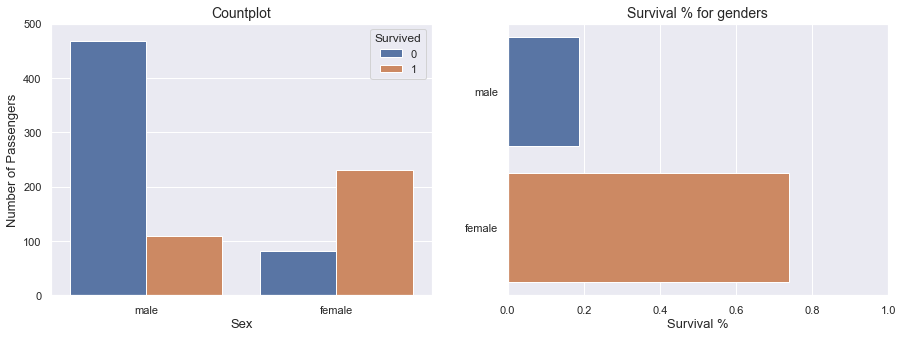

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.countplot(x='Sex',data=df_train,hue='Survived',ax=ax1)
ax1.set_ylim([0,500])
ax1.set_xlabel('Sex',fontdict={'fontsize':13})
ax1.set_ylabel('Number of Passengers',fontdict={'fontsize':13})
ax1.set_title('Countplot',fontdict={'fontsize':14})

sns.barplot(x='Survived',y='Sex',data=df_train,errwidth=0,ax=ax2)
ax2.set_xlim([0,1])
ax2.set_xlabel('Survival %',fontdict={'fontsize':13})
ax2.set_ylabel('',fontdict={'fontsize':13})
ax2.set_title('Survival % for genders',fontdict={'fontsize':14})

plt.show()

Clearly, more % of females survived than the males did. This is understandable since more priority must have been given to the women and children.

Now let's explore relationships between age, fare and the passenger class.

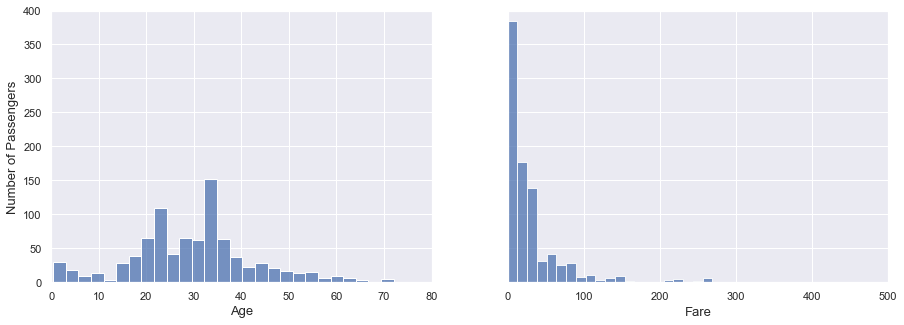

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharey=True)

sns.histplot(df_train['Age'],bins=30,ax=ax1)
ax1.set_xlim([0,80])
ax1.set_ylim([0,400])
ax1.set_xlabel('Age',fontdict={'fontsize':13})
ax1.set_ylabel('Number of Passengers',fontdict={'fontsize':13})
#ax1.set_title('Countplot',fontdict={'fontsize':14})

sns.histplot(df_train['Fare'],ax=ax2,bins=40)
ax2.set_xlim([0,500])
ax2.set_xlabel('Fare',fontdict={'fontsize':13})

plt.show()

- From the age distribution, we see the age concentrated around 30 years and a smaller distribution below 10 years indicating all the child population.
- From the fare distribution, we see that most of the people paid less than 100 bucks. 

We will now explore the age and fare boxplots w.r.t. to passenger class.

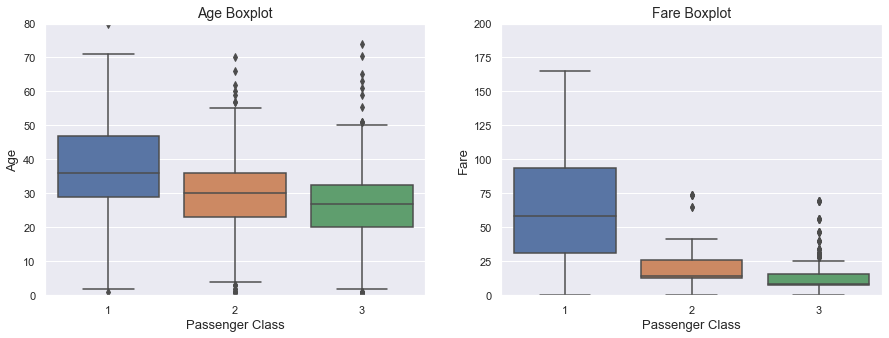

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharex=True)

sns.boxplot(x='Pclass',y='Age',data=df_train,ax=ax1)
ax1.set_ylim([0,80])
ax1.set_xlabel('Passenger Class',fontdict={'fontsize':13})
ax1.set_ylabel('Age',fontdict={'fontsize':13})
ax1.set_title('Age Boxplot',fontdict={'fontsize':14})

sns.boxplot(x='Pclass',y='Fare',data=df_train,ax=ax2)
ax2.set_ylim([0,200])
ax2.set_xlabel('Passenger Class',fontdict={'fontsize':13})
ax2.set_ylabel('Fare',fontdict={'fontsize':13})
ax2.set_title('Fare Boxplot',fontdict={'fontsize':14})

plt.show()

From these boxplots, we can note the following observations:

1. Pclass 1 holds people with mean age around 40 years and has the highest mean fare.
2. Pclass 2 holds people with mean age around 25 years and has the lowest mean fare.

This data makes sense since it's likely to see older people to be wealthy and be capable to pay for a higher class while younger people have either no source of income or just started to earn and hence in the lower passenger class.

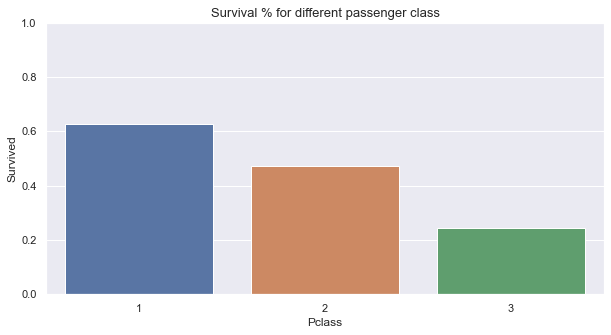

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x='Pclass',y='Survived',data=df_train,errwidth=0)
plt.ylim([0,1])
plt.title('Survival % for different passenger class',fontdict={'fontsize':13})

plt.show()

As we can see here, the higher the passenger class the more likely are the chances of survival

Now we will see if we find any relationship between survival and the ticket type we just extracted from our data

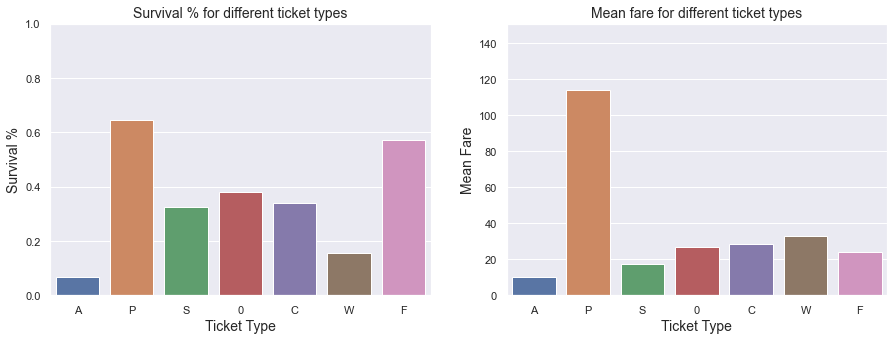

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

sns.barplot(x='Ticket_type',y='Survived',data=df_train,errwidth=0,ax=ax1)
ax1.set_title('Survival % for different ticket types',fontdict={'fontsize':14})
ax1.set_ylim([0,1])
ax1.set_xlabel('Ticket Type',fontdict={'fontsize':14})
ax1.set_ylabel('Survival %',fontdict={'fontsize':14})


sns.barplot(x='Ticket_type',y='Fare',data=df_train,errwidth=0,ax=ax2)
ax2.set_title('Mean fare for different ticket types',fontdict={'fontsize':14})
#ax2.set_ylim([0,1])
ax2.set_xlabel('Ticket Type',fontdict={'fontsize':14})
ax2.set_ylabel('Mean Fare',fontdict={'fontsize':14})

plt.show()

Here on the left, we have a barplot showing us the mean survival rate of each ticket group. We can see that type P has the highest survival % while type A has the lowest.

On the right, we see that the ticket type P has the highest mean fare and the type A has the lowest mean fare. While this does not entirely explain the correlation between ticket type and survival, it does explain why the ticket type P and A have the survival rates we see since higher fare increases the chance of survival and vice versa. Other ticket types like for example 'F' have high chances of survival but the fare value does not explain it.

Thus, it is important for us to include all these features in our training model since any information not explained by one feature might be explained by some other feature.

We will end this EDA section with analysis of number of siblings/spouse and parents/children.

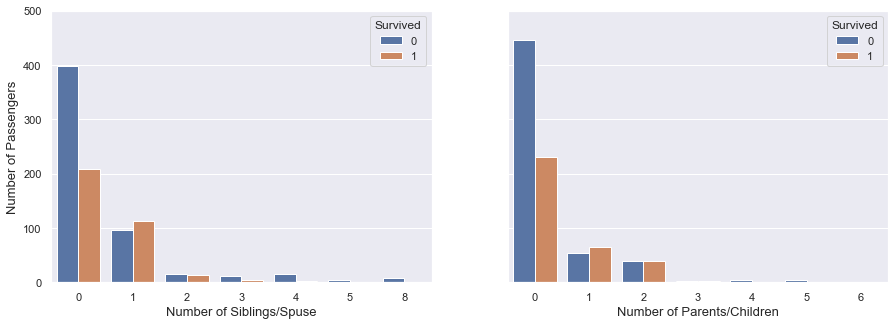

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharey=True)

sns.countplot(x='SibSp',data=df_train,hue='Survived',ax=ax1)
ax1.set_ylim([0,500])
ax1.set_xlabel('Number of Siblings/Spuse',fontdict={'fontsize':13})
ax1.set_ylabel('Number of Passengers',fontdict={'fontsize':13})
ax1.legend(loc='upper right',title='Survived')

sns.countplot(x='Parch',data=df_train,hue='Survived',ax=ax2)
ax2.set_xlabel('Number of Parents/Children',fontdict={'fontsize':13})
ax2.set_ylabel('')
ax2.legend(loc='upper right',title='Survived')

plt.show()

As we can see here, people onboard the titanic with no family with them were less likely to survive as compared to people with family members present.

<br>

# Data Pre-Processing for Test data

This will be done in the exact same fashion for the test.csv as we did it for train.csv and won't be explained

In [25]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [26]:
test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [27]:
df_test = test.copy()

#Extracting title information

df_test['Title'] = df_test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [28]:
df_test['Age'] = df_test['Age'].fillna(df_test.groupby('Title')['Age'].transform('mean'))

In [29]:
# Extracting ticket type information
df_test['Ticket_type'] = df_test['Ticket'].apply(lambda x: x.split()[0] if len(x.split())>1 else '0')
df_test['Ticket_type'] = df_test['Ticket_type'].apply(lambda x: x[0])

Since we have one missing fare data, we will fill that value using the fare mean of the Pclass that the passenger belongs.

In [30]:
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_type
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,0


In [31]:
df_test.fillna(df_test.groupby('Pclass')['Fare'].mean()[3],inplace=True)

In [32]:
df_test.drop(['PassengerId','Name','Ticket','Cabin','Title'],axis=1,inplace=True)
df_test.reset_index(drop=True,inplace=True)
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_type
0,3,male,34.5,0,0,7.8292,Q,0
1,3,female,47.0,1,0,7.0000,S,0
2,2,male,62.0,0,0,9.6875,Q,0
3,3,male,27.0,0,0,8.6625,S,0
4,3,female,22.0,1,1,12.2875,S,0


<br>

# Logistic Regression

Now it's time to implement our logistic regression model, fit the training data onto it and make some predictions!

### Creating dummies

We will create dummies of the categorical variables for both the training and the testing dataset

In [33]:
df_train = pd.get_dummies(df_train,drop_first=True)
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Ticket_type_A,Ticket_type_C,Ticket_type_F,Ticket_type_P,Ticket_type_S,Ticket_type_W
0,0,3,22.0,1,0,7.2500,1,0,1,1,0,0,0,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,0,0,0,1,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,0,0,0,0,0


In [34]:
df_test = pd.get_dummies(df_test,drop_first=True)
df_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Ticket_type_A,Ticket_type_C,Ticket_type_F,Ticket_type_L,Ticket_type_P,Ticket_type_S,Ticket_type_W
0,3,34.5,0,0,7.8292,1,1,0,0,0,0,0,0,0,0
1,3,47.0,1,0,7.0000,0,0,1,0,0,0,0,0,0,0
2,2,62.0,0,0,9.6875,1,1,0,0,0,0,0,0,0,0
3,3,27.0,0,0,8.6625,1,0,1,0,0,0,0,0,0,0
4,3,22.0,1,1,12.2875,0,0,1,0,0,0,0,0,0,0


We see a column named - Ticket_type_L - which is not present in our training dataset. Thus, we need to remove this column.

The implication of removing this column is basically that the Ticket_type_L will become the same as Ticket_type_0 which is our benchmark for this category.

In [35]:
df_test.drop('Ticket_type_L',axis=1,inplace=True)
df_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Ticket_type_A,Ticket_type_C,Ticket_type_F,Ticket_type_P,Ticket_type_S,Ticket_type_W
0,3,34.5,0,0,7.8292,1,1,0,0,0,0,0,0,0
1,3,47.0,1,0,7.0000,0,0,1,0,0,0,0,0,0
2,2,62.0,0,0,9.6875,1,1,0,0,0,0,0,0,0
3,3,27.0,0,0,8.6625,1,0,1,0,0,0,0,0,0
4,3,22.0,1,1,12.2875,0,0,1,0,0,0,0,0,0


### Splitting features and labels

Now we split our training data in x and y variables for the regression

In [36]:
x_train = df_train.drop('Survived',axis=1)
y_train = df_train['Survived']

While it's not necessary, to maintain consistency of nomenclature, we'll copy the test features in a new variable named x_test

In [37]:
x_test = df_test.copy()

### The Model

In [38]:
from sklearn.linear_model import LogisticRegression
reglog = LogisticRegression(max_iter=1000)

In [39]:
reglog.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

We will see how well our model fits the training data and generate some reports

In [40]:
tr_pred = reglog.predict(x_train)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
# Displaying the confusion matrix as a dataframe
pd.DataFrame(confusion_matrix(y_train,tr_pred),index=['Actual 0','Actual 1'],columns=['Predicted 0','Predicted 1'])

,Predicted 0,Predicted 1
Actual 0,486,63
Actual 1,101,239


In [43]:
# Printing the classification report
print(classification_report(y_train,tr_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       549
           1       0.79      0.70      0.74       340

    accuracy                           0.82       889
   macro avg       0.81      0.79      0.80       889
weighted avg       0.81      0.82      0.81       889



We get an accuracy of 82% on our training dataset

Now let's predict the survival of the testing data after which we will create a .csv file for submission to Kaggle

In [44]:
pred = reglog.predict(x_test)

<br>

# Submission file for Kaggle

In [45]:
# Creating a new dataframe with just two columns - PassengerId and Survived (the predicted values)

submission = pd.DataFrame(data=test['PassengerId'],columns=['PassengerId'])
submission['Survived'] = pred

In [46]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [47]:
submission.to_csv('submission.csv',index=False)

This prediction gives a score of 0.787